In [1]:
import os
import requests
import urllib
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import asyncio
from data_quality_utils import Crawler
from sentence_transformers import SentenceTransformer, utilfrom typing import List, Optional, Union
from statistics import mode
from crawl4ai import AsyncWebCrawler, CrawlerRunConfig, CacheMode
from crawl4ai.deep_crawling import BFSDeepCrawlStrategy, BestFirstCrawlingStrategy
from crawl4ai.content_scraping_strategy import LXMLWebScrapingStrategy
from crawl4ai.deep_crawling.scorers import KeywordRelevanceScorer
from crawl4ai.deep_crawling.filters import FilterChain, URLPatternFilter, ContentRelevanceFilter, SEOFilter, ContentTypeFilter
from crawl4ai.markdown_generation_strategy import DefaultMarkdownGenerator
from crawl4ai.content_filter_strategy import BM25ContentFilter
from sentence_transformers import SentenceTransformer, util
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [2]:
# embedding model
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
# suppress warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
# get data from datasette
datasette_base_url = "https://datasette.planning.data.gov.uk/digital-land.csv"

query = """
select * 
from source as s
left join organisation as o
on s.organisation=o.organisation 
where s.collection = "conservation-area"
"""
encoded_query = urllib.parse.urlencode({"sql": query})

r = requests.get(f"{datasette_base_url}?{encoded_query}", auth=('user', 'pass'))

filename = "datasette_data.csv"
with open(filename, "wb") as f_out:
    f_out.write(r.content)

In [4]:
# group by organisation as we're looking for one page per council
data = (
    pl.read_csv(filename)
    .group_by("name")
    .agg(pl.col("website").first(), pl.col("documentation_url"))
)
data = data.with_columns(pl.col("website").str.strip_chars_end("/"))
data

name,website,documentation_url
str,str,list[str]
"""North East Lincolnshire Counci…","""https://www.nelincs.gov.uk""",[null]
"""Blackpool Borough Council""","""https://www.blackpool.gov.uk""",[null]
"""West Berkshire Council""","""https://www.westberks.gov.uk""","[null, ""https://www.westberks.gov.uk/planning-data-conservation-areas""]"
"""Tendring District Council""","""https://www.tendringdc.gov.uk""",[null]
"""St Helens Council""","""https://www.sthelens.gov.uk""","[""https://data.gov.uk/dataset/86bea27d-e174-4a67-aa4b-ee1d3c72a0e8/st-helens-conservation-areas""]"
…,…,…
"""Test Valley Borough Council""","""https://www.testvalley.gov.uk""",[null]
"""Spelthorne Borough Council""","""https://www.spelthorne.gov.uk""",[null]
"""East Suffolk Council""","""https://www.eastsuffolk.gov.uk""","[null, null]"


In [5]:
async def deep_crawl(
    url: str,
    max_depth: int = 6,
    include_external: bool = False,
    url_patterns: Optional[List[str]] = None,
    keyword_scorer: Optional[dict] = None,
    filters: Optional[List[Union[dict, object]]] = None,
    cache_enabled: bool = False
):
    """
    Performs a deep crawl on the given URL with customizable scoring and filtering options.

    Parameters:
    - url (str): The starting URL.
    - max_depth (int): Maximum depth for crawling (default: 6).
    - include_external (bool): Whether to include external links (default: False).
    - keyword_scorer (dict, optional): Dictionary with 'keywords' (list) and 'weight' (float).
    - filters (List[Union[dict, object]], optional): List of filter configurations or filter instances.
    - cache_enabled (bool): Whether to enable caching (default: True).

    Returns:
    - A list of CrawlResult containing:
        - "url": The crawled url.
        - "markdown": Raw markdown of the page at url.
    """

    # Initialize filters list
    filter_list = []
    # Initialise None object for BM25 filter
    md_generator = None

    # Add user-defined filters (supporting both dict and object instances)
    if filters:
        for f in filters:
            if isinstance(f, dict):
                filter_type = f.get("type")
                if filter_type == "SEOFilter":
                    filter_list.append(SEOFilter(threshold=f.get("threshold", 0.6), keywords=f.get("keywords", [])))
                elif filter_type == "ContentRelevanceFilter":
                    filter_list.append(ContentRelevanceFilter(query=f.get("query", ""), threshold=f.get("threshold", 0.2)))
                elif filter_type == "ContentTypeFilter":
                    filter_list.append(ContentTypeFilter(allowed_types=f.get("allowed_types", ["text/html"])))
                elif filter_type == "URLPatternFilter":
                    filter_list.append(URLPatternFilter(patterns=f.get("patterns", [])))
                elif filter_type == "BM25ContentFilter":
                    bm25_filter = BM25ContentFilter(
                    user_query=f.get("query", ""),
                    bm25_threshold=f.get("threshold", 0.8))
                    md_generator = DefaultMarkdownGenerator(content_filter=bm25_filter, options={"ignore_links": True})

            elif isinstance(f, object):
                filter_list.append(f)

    # Add URL scoring strategy
    url_scorer = None
    if keyword_scorer:
        url_scorer = KeywordRelevanceScorer(
            keywords=keyword_scorer.get("keywords", []),
            weight=keyword_scorer.get("weight", 1.0)
        )

    # Create crawler configuration
    config = CrawlerRunConfig(
        deep_crawl_strategy=BestFirstCrawlingStrategy(
            max_depth=max_depth,
            include_external=include_external,
            url_scorer=url_scorer,
            filter_chain=FilterChain(filter_list),
        ),
        scraping_strategy=LXMLWebScrapingStrategy(),
        cache_mode=CacheMode.ENABLED if cache_enabled else CacheMode.BYPASS,
        verbose=False,
        markdown_generator=md_generator
    )

    crawl_data = []

    # Run the crawler
    async with AsyncWebCrawler() as crawler:
        results = await crawler.arun(url, config=config)
        print(f"Crawled {len(results)} pages in total")

        for result in results:
            if result.success:
                crawl_data.append((result.url, result.markdown.raw_markdown))

    return crawl_data

In [6]:
# chunk_size = 300, chunk_overlap = 50, separators = ["##", "\n\n", ". ", " ", ""], keep_separator = False

In [7]:
def split_text(text, chunk_size, chunk_overlap, separators, keep_separator):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,  
        separators=separators,
        keep_separator=keep_separator
    )

    chunks = text_splitter.split_text(text)
    return chunks

In [8]:
def chunk_processing(crawl_data, chunk_size, chunk_overlap, separators, keep_separator):
    chunking_data = list()
    
    for url, markdown in crawl_data:
        chunk_texts = split_text(markdown, chunk_size, chunk_overlap, separators, keep_separator)
        for chunk_num, chunk in enumerate(chunk_texts):
            chunk_id = f"{url}-{chunk_num}" # To have unique id for data.
            chunking_data.append((chunk_id, url, chunk_num, chunk))
    
    chunked_df = pl.DataFrame(chunking_data, 
                              schema=["id", "url", "chunk_num", "text"], orient="row")
    
    embeddings = embedding_model.encode(chunked_df['text'].to_list(), convert_to_numpy=True)
    chunked_df = chunked_df.with_columns(pl.Series(name="embedding", values=embeddings))
    
    return chunked_df

In [9]:
def basic_processing(crawl_data):
    basic_data = list()
    
    for url, markdown in crawl_data: 
        basic_data.append((f"{url}-0", url, 0, markdown))
    
    basic_df = pl.DataFrame(basic_data, 
                            schema=["id", "url", "chunk_num", "text"], orient="row")
    
    embeddings = embedding_model.encode(basic_df['text'].to_list(), convert_to_numpy=True)
    basic_df = basic_df.with_columns(pl.Series(name="embedding", values=embeddings))

    return basic_df

In [10]:
def get_similar_urls(
        crawl_data, 
        prompt, 
        num_results, 
        chunking,
        chunk_size, 
        chunk_overlap, 
        separators, 
        keep_separator,
        ):
    """
    Embeds crawled webpage data, computes similarity to a given prompt, and returns the top N most similar pages.

    Parameters:
    - crawl_data (list of tuples): A list of tuples containing (url, markdown) for each crawled page.
    - prompt (str): The text prompt to compare against the crawled page embeddings.
    - num_results (int, optional): The number of top similar pages to return. If None, returns all pages.
    - chunking (bool, optional): Whether we want to embed the full webpage or chunk.

    Returns:
    - polars.DataFrame: A DataFrame containing:
        - "url": The webpage URL.
        - "markdown": The extracted markdown content.
        - "embedding": The computed embedding for the content.
        - "similarity": The cosine similarity score with the prompt.
    """
    res = []
    
    if chunking:
        crawl_df = chunk_processing(
            crawl_data = crawl_data,
            chunk_size = chunk_size, 
            chunk_overlap = chunk_overlap, 
            separators = separators, 
            keep_separator = keep_separator
        )
    elif not chunking:
        crawl_df = basic_processing(crawl_data)
    
    embeddings = np.stack(crawl_df["embedding"].to_list())
    
    prompt_embedding = np.array(embedding_model.encode(prompt, convert_to_numpy=True), dtype='float64')
    
    # get similarity scores
    sim=util.cos_sim(
        prompt_embedding.astype(np.float32), 
        embeddings.astype(np.float32)
    )
    # get indices of top n most similar urls
    if not num_results:
        num_results = len(crawl_df)
    indices = np.argsort(sim).numpy().flatten()[:-num_results-1:-1]
    sorted_df = (
        crawl_df[indices]
        .with_columns(similarity=np.sort(sim).flatten()[:-num_results-1:-1])
    )
    return sorted_df

In [6]:
def pretty_print_results(sorted_df, num_printing_results):
    # print top n urls with similarity scores
    print("\nTop Similar Pages:\n" + "="*40)
    for i in range(min(num_printing_results, len(sorted_df))):
        url = sorted_df.get_column("url")[i]
        score = sorted_df.get_column("similarity")[i]
        print(f"{i+1}. {url.ljust(60)} | Similarity: {score:.4f}")

In [13]:
def load_csv_data(file_path):
  pl.Config.set_float_precision(10)
  #To give some more readiability, regardless of what is shown the numbers ARE the same!
  df = pl.read_csv(file_path)
  cleaned_df = df.with_columns(
      pl.col("embedding")
        .str.strip_chars("[]")
        .str.replace_all("\n", '')
        .str.strip_chars(" ")
        .str.split(' ')
        .list.eval(pl.element().filter(pl.element() != ""))
        .list.eval(pl.element().cast(pl.Float32, strict=False))
  )
  return cleaned_df

In [14]:
async def process_council(
    council_names,
    max_depth=6,
    keyword_scorer=None,
    filters=None,
    prompt="A page about conservation areas.",
    cache_enabled=False,
    num_results=None,
    num_printing_results=10,
    save_dfs = False,
    load_dfs = False,
    data_dir = '',
    chunking = False,
    chunk_size = 300, 
    chunk_overlap = 50, 
    separators = ["##", "\n\n", ". ", " ", ""], 
    keep_separator = False,
):
    crawler = Crawler(
            max_depth=max_depth,
            keyword_scorer=keyword_scorer,
            filters=filters,
            cache_enabled=cache_enabled,
        )
    
    crawled_dfs = dict()

    for council_name in council_names:
        council_data = data.filter(pl.col("name").str.contains(council_name))
        short_council_name = council_data.get_column("website")[0].split('.')[1]
        full_name = council_data.get_column("name")[0]
        homepage = council_data.get_column("website")[0]
        prompt = prompt.format((full_name).replace('\n', ''))
        save_path = f"{data_dir}{short_council_name}.csv"

        print("="*40 + f"\nProcessing {full_name}...\n")
        
        if os.path.isdir(data_dir) and load_dfs:
            if f"{short_council_name}.csv" in os.listdir(data_dir): 
                sorted_df = load_csv_data(save_path)
                pretty_print_results(sorted_df, num_printing_results)
                crawled_dfs[homepage] = sorted_df
                continue
            
        # crawl url
        crawl_data = await crawler.deep_crawl(homepage)
        
        # get markdown embeddings
        sorted_df = get_similar_urls(
            crawl_data = crawl_data, 
            prompt = prompt,
            num_results=num_results, 
            chunking=chunking,
            chunk_size = chunk_size, 
            chunk_overlap = chunk_overlap, 
            separators = separators, 
            keep_separator = keep_separator
        )
        
        sorted_df = sorted_df.with_columns(pl.col("url").str.strip_chars_end("/"))
        
        pretty_print_results(sorted_df, num_printing_results)

        if save_dfs:
            save_df = sorted_df.to_pandas()
            save_df.to_csv(save_path)

        crawled_dfs[homepage] = sorted_df
    
    return crawled_dfs

## Our approach

Our approach involves 2 main steps: a web crawler and an embedding similarity search. Below is a description of these steps.

### Web crawler

The web crawler takes a homepage URL of an organisation (council website) and crawls it to look for pages talking about conservation areas.

The crawler will look for links on a single page, put them in a queue and then iteratively check them until it finds what it was looking for or it reaches a stopping criterion, such as maximum depth (how many clicks away from home page). 

In order to save time, we can define some scorers or filters which tell the crawler which pages to prioritise or ignore. In this case, some common patterns of what a user needs to click to get to the page of interest are _"planning"_, _"building"_, _"heritage"_ or _"conservation"_.

The crawler uses a *"best first strategy"*, which utilises the scorers or filters to visit most relevant sites first, rather than a depth-first or breath-first search.

The crawler extracts the HTML from the pages and turns them into markdown. This is because it's more readable and easier to work with in the next steps. The crawler returns a list of pairs of (_url_, _markdown_).

### Embedding search

To be filled

### The next few cells show how to use the tools to find conservation area pages.

You can define your own parameters, such as maximum depth, how many results you want to see and any scorers or filters. Below is a template showing how to defin each scorer/filter type correctly - all you need to do is change the keywords or patterns.

You can also define a prompt - this is what will be used to get embeddings scores for a webpage. The more similar the prompt is to what a conservation area page usually looks like, the more accurate the results.

Lastly, you can await the `process_council` function, which will run the functionality described above and print the results. You can use it for one council only or for a list of councils.

#### Template for how to define filters or scorers
##### Pick the types you need and adjust their parameter (keywords, threshold, ...) and pass them to the crawler function.
    keyword_scorer = {
        "keywords": ["conservation", "conservation area", "planning", "building", "urban", "heritage", "resident"],
        "weight": 0.8,
    }
        
    filters=[
        {"type": "SEOFilter", "threshold": 0.6, "keywords": ["conservation", "area", "planning", "heritage", "resident"]},
        {"type": "ContentRelevanceFilter", "query": "conservation area or planning data", "threshold": 0.2},
        {"type": "ContentTypeFilter", "allowed_types": ["text/html"]},
        {"type": "URLPatternFilter", "patterns": ["*conservation*", "*planning*", "*building*"]},
    ]

### Gedling

In [8]:
max_depth = 6
num_results = 100
filters=[
    {"type": "ContentTypeFilter", "allowed_types": ["text/html"]},
    {"type": "URLPatternFilter", "patterns": ["*conservation*", "*planning*", "*building*"]},
]

# please write the prompt such that there is a curly bracket where the council
# name will be inserted
prompt = """
The text discusses conservation areas from the {} and includes data on 
planning data, areas, interactive maps, appraisals, notices, boundaries, 
links and similar.
"""

df = await process_council(
    council_names=["Gedling"], 
    max_depth=max_depth, 
    filters=filters, 
    prompt=prompt, 
    # num_results=num_results
)

Processing Gedling Borough Council...

[INIT].... → Crawl4AI 0.5.0.post4
Crawled 137 pages in total

Top Similar Pages:
1. https://www.gedling.gov.uk/conservation/#page                | Similarity: 0.6600
2. https://www.gedling.gov.uk/conservation/                     | Similarity: 0.6600
3. http://www.gedling.gov.uk/resident/planningandbuildingcontrol/ | Similarity: 0.6419
4. http://www.gedling.gov.uk/resident/planningandbuildingcontrol/#page | Similarity: 0.6419
5. https://www.gedling.gov.uk/resident/planningandbuildingcontrol/ | Similarity: 0.6416
6. https://www.gedling.gov.uk/resident/planningandbuildingcontrol/#page | Similarity: 0.6416
7. https://www.gedling.gov.uk/resident/planningandbuildingcontrol/planningpolicy/naturalenvironment/ | Similarity: 0.6250
8. https://www.gedling.gov.uk/resident/planningandbuildingcontrol/planningpolicy/naturalenvironment/#page | Similarity: 0.6250
9. http://www.gedling.gov.uk/resident/planningandbuildingcontrol/planningpolicy/ | Similarity: 0.6018

{'https://www.gedling.gov.uk': shape: (137, 6)
 ┌──────────────────┬──────────────────┬───────────┬─────────────────┬─────────────────┬────────────┐
 │ id               ┆ url              ┆ chunk_num ┆ text            ┆ embedding       ┆ similarity │
 │ ---              ┆ ---              ┆ ---       ┆ ---             ┆ ---             ┆ ---        │
 │ str              ┆ str              ┆ i64       ┆ str             ┆ array[f32, 384] ┆ f32        │
 ╞══════════════════╪══════════════════╪═══════════╪═════════════════╪═════════════════╪════════════╡
 │ https://www.gedl ┆ https://www.gedl ┆ 0         ┆ [Skip to conten ┆ [0.079654,      ┆ 0.659998   │
 │ ing.gov.uk/con…  ┆ ing.gov.uk/con…  ┆           ┆ t](https://www. ┆ 0.027447, …     ┆            │
 │                  ┆                  ┆           ┆ …               ┆ 0.07965…        ┆            │
 │ https://www.gedl ┆ https://www.gedl ┆ 0         ┆ [Skip to conten ┆ [0.079654,      ┆ 0.659998   │
 │ ing.gov.uk/con…  ┆ ing.gov.uk/co

### South Gloucestershire

In [8]:
max_depth = 6
num_results = 10
filters=[
    {"type": "ContentTypeFilter", "allowed_types": ["text/html"]},
    {"type": "URLPatternFilter", "patterns": ["*conservation*", "*planning*", "*building*"]},
]

# please write the prompt such that there is a curly bracket where the council
# name will be inserted
prompt = """
The text discusses conservation areas from the {} and includes data on 
planning data, areas, interactive maps, appraisals, notices, boundaries, 
links and similar.
"""

await process_council(
    council_names=["South Gloucestershire"], 
    max_depth=max_depth, 
    filters=filters, 
    prompt=prompt, 
    num_results=num_results
)

Processing South Gloucestershire Council...

[INIT].... → Crawl4AI 0.5.0.post4


### Bournemouth, Christchurch and Poole

In [13]:
max_depth = 6
num_results = 10
filters=[
    {"type": "ContentTypeFilter", "allowed_types": ["text/html"]},
    {"type": "URLPatternFilter", "patterns": ["*conservation*", "*planning*", "*building*"]},
]

# please write the prompt such that there is a curly bracket where the council
# name will be inserted
prompt = """
The text discusses conservation areas from the {} and includes data on 
planning data, areas, interactive maps, appraisals, notices, boundaries, 
links and similar.
"""

await process_council(
    council_names=["Bournemouth, Christchurch and Poole"], 
    max_depth=max_depth, 
    filters=filters, 
    prompt=prompt, 
    num_results=num_results
)

Processing Bournemouth, Christchurch and Poole Council...

[INIT].... → Crawl4AI 0.5.0.post4
Crawled 504 pages in total

Top Similar Pages:
1. https://www.bcpcouncil.gov.uk/planning-and-building-control/urban-design-trees-and-conservation/conservation-areas | Similarity: 0.6143
2. https://www.bcpcouncil.gov.uk/planning-and-building-control/urban-design-trees-and-conservation/conservation-areas#guide-contents | Similarity: 0.6143
3. https://www.bcpcouncil.gov.uk/planning-and-building-control/urban-design-trees-and-conservation/conservation-areas#main | Similarity: 0.6143
4. https://bcpcouncil.gov.uk/planning-and-building-control/local-land-charges | Similarity: 0.6074
5. https://bcpcouncil.gov.uk/planning-and-building-control/local-land-charges#guide-contents | Similarity: 0.6074
6. https://bcpcouncil.gov.uk/planning-and-building-control/local-land-charges#main | Similarity: 0.6074
7. https://bcpcouncil.gov.uk/planning-and-building-control/urban-design-trees-and-conservation/listed-buil

### Warrington

In [9]:
max_depth = 6
num_results = 10
filters=[
    {"type": "ContentTypeFilter", "allowed_types": ["text/html"]},
    {"type": "URLPatternFilter", "patterns": ["*conservation*", "*planning*", "*building*"]},
]

# please write the prompt such that there is a curly bracket where the council
# name will be inserted
prompt = """
The text discusses conservation areas from the {} and includes data on 
planning data, areas, interactive maps, appraisals, notices, boundaries, 
links and similar.
"""

await process_council(
    council_names=["Warrington"], 
    max_depth=max_depth, 
    filters=filters, 
    prompt=prompt, 
    num_results=num_results
)

Processing Warrington Borough Council...

[INIT].... → Crawl4AI 0.5.0.post4
Crawled 67 pages in total

Top Similar Pages:
1. https://www.warrington.gov.uk/nature-conservation#main-content | Similarity: 0.6056
2. https://www.warrington.gov.uk/nature-conservation            | Similarity: 0.6056
3. https://online.warrington.gov.uk/planning/index.html         | Similarity: 0.5629
4. https://online.warrington.gov.uk/planning/                   | Similarity: 0.5513
5. https://www.warrington.gov.uk/supplementary-planning-documents-consultation | Similarity: 0.5456
6. https://www.warrington.gov.uk/supplementary-planning-documents-consultation#main-content | Similarity: 0.5456
7. https://www.warrington.gov.uk/supplementary-planning-documents | Similarity: 0.5359
8. https://www.warrington.gov.uk/supplementary-planning-documents#main-content | Similarity: 0.5359
9. https://www.warrington.gov.uk/planning-policy-archives#main-content | Similarity: 0.5312
10. https://www.warrington.gov.uk/planning-p

### Stoke on Trent

In [10]:
max_depth = 6
num_results = 10
filters=[
    {"type": "ContentTypeFilter", "allowed_types": ["text/html"]},
    {"type": "URLPatternFilter", "patterns": ["*conservation*", "*planning*", "*building*"]},
]

# please write the prompt such that there is a curly bracket where the council
# name will be inserted
prompt = """
The text discusses conservation areas from the {} and includes data on 
planning data, areas, interactive maps, appraisals, notices, boundaries, 
links and similar.
"""

await process_council(
    council_names=["Stoke"], 
    max_depth=max_depth, 
    filters=filters, 
    prompt=prompt, 
    num_results=num_results
)

Processing Stoke-on-Trent City Council...

[INIT].... → Crawl4AI 0.5.0.post4
Crawled 129 pages in total

Top Similar Pages:
1. https://www.stoke.gov.uk/info/20005/planning_and_building/547/conservation_areas#content | Similarity: 0.8232
2. https://www.stoke.gov.uk/info/20005/planning_and_building/547/conservation_areas | Similarity: 0.8232
3. https://www.stoke.gov.uk/news/article/1509/council_announces_new_conservation_areas#content | Similarity: 0.8073
4. https://www.stoke.gov.uk/news/article/1509/council_announces_new_conservation_areas | Similarity: 0.8073
5. https://www.stoke.gov.uk/news/article/1285/changes_to_conservation_areas_in_stoke-on-trent | Similarity: 0.7924
6. https://www.stoke.gov.uk/news/article/1285/changes_to_conservation_areas_in_stoke-on-trent#content | Similarity: 0.7924
7. https://www.stoke.gov.uk/conservationareas#content           | Similarity: 0.7902
8. http://www.stoke.gov.uk/conservationareas                    | Similarity: 0.7902
9. https://www.stoke.gov.u

### Redbridge

In [14]:
max_depth = 6
num_results = 10
filters=[
    {"type": "ContentTypeFilter", "allowed_types": ["text/html"]},
    {"type": "URLPatternFilter", "patterns": ["*conservation*", "*planning*", "*building*"]},
]

# please write the prompt such that there is a curly bracket where the council
# name will be inserted
prompt = """
The text discusses conservation areas from the {} and includes data on 
planning data, areas, interactive maps, appraisals, notices, boundaries, 
links and similar.
"""

await process_council(
    council_names=["Redbridge"], 
    max_depth=max_depth, 
    filters=filters, 
    prompt=prompt, 
    num_results=num_results
)

Processing London Borough of Redbridge...

[INIT].... → Crawl4AI 0.5.0.post4
Crawled 762 pages in total

Top Similar Pages:
1. https://www.redbridge.gov.uk/planning-and-building/protected-buildings-and-conservation-areas/article-4-direction-c4-hmos/ | Similarity: 0.6607
2. https://www.redbridge.gov.uk/planning-and-building/protected-buildings-and-conservation-areas/article-4-direction-c4-hmos/#accessibilitySkip | Similarity: 0.6607
3. https://www.redbridge.gov.uk/planning-and-building/protected-buildings-and-conservation-areas/ | Similarity: 0.6513
4. https://www.redbridge.gov.uk/planning-and-building/protected-buildings-and-conservation-areas/#accessibilitySkip | Similarity: 0.6513
5. https://www.redbridge.gov.uk/Account/Register?returnurl=%2Fplanning-and-building%2Fprotected-buildings-and-conservation-areas%2Farticle-4-direction-c4-hmos%2F&clientid=RedbridgeCMSLive#accessibilitySkip | Similarity: 0.6512
6. https://www.redbridge.gov.uk/Account/Register?returnurl=%2Fplanning-and-buildi

### York

In [25]:
max_depth = 6
num_results = 10
filters=[
    {"type": "ContentTypeFilter", "allowed_types": ["text/html"]},
    {"type": "URLPatternFilter", "patterns": [r"*[Cc]onservation*", r"*[Pp]lanning*", r"*[Bb]uilding*"]},
]

# please write the prompt such that there is a curly bracket where the council
# name will be inserted
prompt = """
The text discusses conservation areas from the {} and includes data on 
planning data, areas, interactive maps, appraisals, notices, boundaries, 
links and similar.
"""

await process_council(
    council_names=["York"], 
    max_depth=max_depth, 
    filters=filters, 
    prompt=prompt, 
    num_results=num_results
)

Processing York...

[INIT].... → Crawl4AI 0.5.0.post4
Crawled 3260 pages in total

Top Similar Pages:
1. https://planningaccess.york.gov.uk/online-applications/#top  | Similarity: 0.4857
2. https://planningaccess.york.gov.uk/online-applications/#pageheading | Similarity: 0.4857
3. https://planningaccess.york.gov.uk/online-applications/      | Similarity: 0.4857
4. https://www.york.gov.uk/conservation-listed-buildings/york-central-historic-core-conservation-area-appraisal-hccaa#content | Similarity: 0.4832
5. https://www.york.gov.uk/conservation-listed-buildings/york-central-historic-core-conservation-area-appraisal-hccaa | Similarity: 0.4832
6. https://www.york.gov.uk/conservation-listed-buildings/york-central-historic-core-conservation-area-appraisal-hccaa#js-menu | Similarity: 0.4832
7. https://www.york.gov.uk/conservation-listed-buildings/york-central-historic-core-conservation-area-appraisal-hccaa#top | Similarity: 0.4832
8. https://www.york.gov.uk/conservation-listed-buildings/yor

### Malvern Hills

In [ ]:
max_depth = 6
num_results = 10
filters=[
    {"type": "ContentTypeFilter", "allowed_types": ["text/html"]},
    {"type": "URLPatternFilter", "patterns": [r"*[Cc]onservation*", r"*[Pp]lanning*", r"*[Bb]uilding*"]},
]

# please write the prompt such that there is a curly bracket where the council
# name will be inserted
prompt = """
The text discusses conservation areas from the {} and includes data on 
planning data, areas, interactive maps, appraisals, notices, boundaries, 
links and similar.
"""

await process_council(
    council_names=["Malvern Hills"], 
    max_depth=max_depth, 
    filters=filters, 
    prompt=prompt, 
    num_results=num_results
)

Processing Malvern Hills...

[INIT].... → Crawl4AI 0.5.0.post4


## Multiple councils

You can define any list of councils and their processing will be executed sequentially

In [29]:
np.random.seed(4321)
num_examples = 10
example_idx = np.random.randint(0, len(data), num_examples)
examples = data[example_idx]
examples

name,website,documentation_url
str,str,list[str]
"""Canterbury City Council""","""https://www.canterbury.gov.uk""","[""https://mapping.canterbury.gov.uk/arcgis/rest/services/External/Planning_Constraints_New/MapServer""]"
"""Leicester City Council""","""https://www.leicester.gov.uk""","[""https://data.gov.uk/dataset/e702ebff-27b4-4e86-acbb-74d066f3c4e7/conservation-areas"", ""https://data.leicester.gov.uk/explore/?q=conservation+area&sort=modified"", ""https://data.leicester.gov.uk/explore/?q=conservation+area&sort=modified""]"
"""Gateshead Metropolitan Borough…","""https://www.gateshead.gov.uk""","[null, ""https://gateshead-council-open-data-gateshead.hub.arcgis.com/datasets/Gateshead::spe-hx-conservation-areas/about""]"
"""Runnymede Borough Council""","""https://www.runnymede.gov.uk""",[null]
"""Birmingham City Council""","""https://www.birmingham.gov.uk""","[null, null, … ""https://openplanningdata-sbham.hub.arcgis.com/datasets/ee06653284154ccfb4fec1e9428760e1/about""]"
"""Thurrock Thames Gateway Develo…","""https://www.gov.uk/government/…",[null]
"""Basildon Borough Council""","""https://www.basildon.gov.uk""",[null]
"""London Borough of Richmond upo…","""https://www.richmond.gov.uk""",[null]
"""Ministry of Housing, Communiti…","""https://www.gov.uk/government/…","[""https://dluhc-datasets.planning-data.dev/dataset/conservation-area-document-type"", ""https://github.com/digital-land/conservation-area-data/tree/main/data/Output/Missing"", … ""https://dataset-editor.development.planning.data.gov.uk/dataset/conservation-area-document-type""]"


In [ ]:
max_depth = 6
num_results = 10
filters=[
    {"type": "ContentTypeFilter", "allowed_types": ["text/html"]},
    {"type": "URLPatternFilter", "patterns": ["*conservation*", "*planning*", "*building*"]},
]

# please write the prompt such that there is a curly bracket where the council
# name will be inserted
prompt = """
The text discusses conservation areas from the {} and includes data on 
planning data, areas, interactive maps, appraisals, notices, boundaries, 
links and similar.
"""

await process_council(
    council_names=examples.get_column("name"), 
    max_depth=max_depth, 
    filters=filters, 
    prompt=prompt, 
    num_results=num_results
)

## Evaluating Results

For this section we manually labelled 25 councils with their true page. We perform tests and ranking here to assess the performance of our model. First we import a manually defined list of true documentation urls as test_df, and filter our main dataset for that. We also strip the final slash and will clean urls in other ways throughout.

In [16]:
test_df = pl.read_csv("data/page_ranking_truth_df.csv")
test_df = test_df.with_columns(pl.col("correct_documentation_url").str.strip_chars_end("/"))
test_website_list = test_df["website"].to_list()
data_filtered = data.filter(pl.col("website").is_in(test_website_list))
combined_df = data_filtered.join(test_df, on='website')

The next cell parses all councils in our test set. This takes some time to run, but there is functionality for saving and loading data.

In [17]:
max_depth = 6
num_results = 100
num_printing_results = 10
filters=[
    {"type": "ContentTypeFilter", "allowed_types": ["text/html"]},
    {"type": "URLPatternFilter", "patterns": [r"*[Cc]onservation*", r"*[Pp]lanning*", r"*[Bb]uilding*"]},
]

# please write the prompt such that there is a curly bracket where the council
# name will be inserted
prompt = """
Conservation Areas in {}

We are committed to preserving the historic and architectural character of our borough
through designated conservation areas. These areas protect buildings, streets, and 
landscapes of special significance, ensuring that any changes respect their unique heritage. 
If you live or own property in a conservation area, additional planning controls may 
apply to alterations, demolitions, and new developments. Our aim is to balance modern 
needs with the protection of our historic environment. For more information on conservation 
area guidelines, planning applications, and how you can contribute to local heritage preservation, 
please visit our planning and conservation pages. You will find maps, appraisal documents and the
list of council conservation areas. 
"""
# Fair warning, this will take multiple hours to run in its entirety. 

test_output_dict = await process_council(
    council_names=combined_df.get_column("name"), # Just the first 5 takes 20 mins.
    max_depth=max_depth, 
    filters=filters,        
    prompt=prompt, 
    num_results=num_results,
    num_printing_results=num_printing_results,
    save_dfs = True, # Uncomment if you want to save your parsed table. This will overwrite anything in the data_dir, so do change if needed.
    load_dfs = True, # Uncomment if you want to quickly load previous parses from data_dir. This will lead to no scraping being done.
    data_dir = 'data/chunking_csvs/',
    chunking = True, # Set to False if you would like the entire webpage embedded, not chunks.
    chunk_size=500,
    chunk_overlap=75
)

Processing Gloucester City Council...


Top Similar Pages:
1. https://www.gloucester.gov.uk/planning-development/conservation-regeneration/conservation-areas | Similarity: 0.8656
2. https://www.gloucester.gov.uk/planning-development/conservation-regeneration/conservation-areas/#main-content | Similarity: 0.8656
3. https://www.gloucester.gov.uk/planning-development/planning-applications/planning-applications-faqs | Similarity: 0.8349
4. https://www.gloucester.gov.uk/planning-development/planning-applications/planning-applications-faqs/#main-content | Similarity: 0.8349
5. https://www.gloucester.gov.uk/planning-development/planning-applications/planning-applications-faqs | Similarity: 0.8349
6. https://www.gloucester.gov.uk/planning-development/planning-applications/planning-applications-faqs/#main-content | Similarity: 0.8349
7. https://www.gloucester.gov.uk/planning-development/conservation-regeneration/conservation-areas | Similarity: 0.7677
8. https://www.gloucester.gov.uk/planning-d

In [18]:
def url_cleaning(df, col):
    df = df.with_columns(pl.col(col).str.replace(
        "http://", "https://", literal=True))
    df = df.with_columns(pl.col(col).str.replace(
        "www.", "", literal=True))
    df = df.with_columns(pl.col(col).str.strip_chars_end("/"))
    return df

In [19]:
def remove_duplicates(df):
    df = url_cleaning(df, 'url')
    df = url_cleaning(df, 'id')

    df = df.sort("similarity", descending=True)
    # We only want the best chunk (if chunking) from each webpage.
    df = df.group_by("url", maintain_order=True).first()
    df = df.sort(by = 'similarity', descending=True)

    return df

In [20]:
def get_result_rank(correct_webpage, df):
    # Here we get an ordered list of the similarity scores, along with the best one.
    # Note, multiple rows may have the same similarity.
    similarity_scores = list(set(df['similarity']))
    sorted_similarity_scores = sorted(similarity_scores, reverse=True)
    result_rows = df.filter(pl.col('url') == correct_webpage)
    best_similarity_score = result_rows['similarity'][0]

    # Now we acquire the rank of the embedding score achieved by our pipeline.
    rank = sorted_similarity_scores.index(best_similarity_score) + 1
    print(f'rank is {rank} with similarity {best_similarity_score}')
    return rank

In [21]:
def test_ranking_processing(test_df: pl.dataframe.frame.DataFrame, test_output_dict: dict, outlier_threshold: int = 1000):
    """Processing to analyse the ranking of our pipeline's embedding guesses. 

    :param test_df: polars.DataFrame with columns:
        - "website": The base website of the council
        - "correct_documentation_url": The manually judged correct webpage. This should have the largest embedding similarity.
    :param test_output_dict: dictionary with outputs of webscraping and embedding. Keys are base websites and values are dataframes.
    :param outlier_threshold: Threshold for ranks beyond which results are assumed false/failure. If above, not saved in ranking_dict.
    :return: 
        ranking_dict: Dictionary with ranks for each website. Base websites are keys, ranks are values
        num_unclassified: Quantity of failed experiments, where no website match could be found.
        num_outliers: Quantity of experiments leading to outliers.
    """
    
    ranking_dict = dict()
    filtered_output_dict = {url: remove_duplicates(df)
                        for url, df in test_output_dict.items()}
    
    num_unclassified = 0
    num_outliers = 0

    for base_website, similarity_df in filtered_output_dict.items():
        print(f'processing {base_website}')
        try:
            correct_webpage = test_df.filter(pl.col('website') == base_website)['correct_documentation_url'][0]
            rank = get_result_rank(correct_webpage, similarity_df)
            if rank >= outlier_threshold:
                print(f"Outlier for this url - rank of {rank} - leaving out of plot")
                num_outliers += 1
                continue
            
            ranking_dict[base_website] = rank
        
        except IndexError as e:
            print(f"No match for correct website via urls - error message '{e}'")
            num_unclassified += 1 
                
    return ranking_dict, num_unclassified, num_outliers

In [22]:
test_df = url_cleaning(test_df, 'correct_documentation_url')
ranking_dict, num_unclassified, num_outliers = test_ranking_processing(test_df, 
                                                                       test_output_dict, 
                                                                       outlier_threshold=30)

processing https://www.gloucester.gov.uk
rank is 1 with similarity 0.8655903
processing https://www.great-yarmouth.gov.uk
rank is 1 with similarity 0.6942468
processing https://www.southglos.gov.uk
rank is 1 with similarity 0.79201794
processing https://www.epsom-ewell.gov.uk
rank is 1 with similarity 0.6909757
processing https://www.westberks.gov.uk
rank is 3 with similarity 0.6085992
processing https://www.rother.gov.uk
rank is 1 with similarity 0.6898212
processing https://www.n-somerset.gov.uk
rank is 1 with similarity 0.7221939
processing https://www.lbbd.gov.uk
rank is 1 with similarity 0.68294704
processing https://www.rossendale.gov.uk
rank is 1 with similarity 0.6271126
processing https://www.torbay.gov.uk
rank is 1 with similarity 0.6477931
processing https://www.dover.gov.uk
No match for correct website via urls - error message 'index 0 is out of bounds for sequence of length 0'
processing https://www.sandwell.gov.uk
rank is 1 with similarity 0.6270152
processing https://www

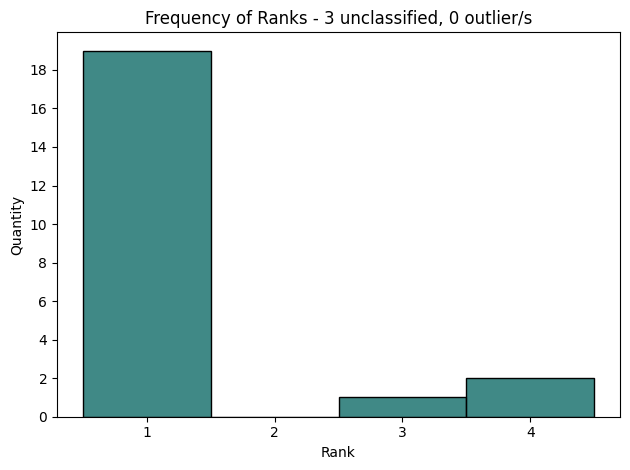

In [23]:
ranks = list(ranking_dict.values())
height = ranks.count(mode(ranks))

ax = sns.histplot(x=ranks, binwidth=1, discrete=True, color='#00625E')
ax.set_title(f'Frequency of Ranks - {num_unclassified} unclassified, {num_outliers} outlier/s')
ax.set_xlabel('Rank')
ax.set_ylabel('Quantity')
ax.set_xticks(np.arange(1, max(ranks)+1))
ax.set_yticks(np.arange(0, height+1, 2))
ax.set_xticklabels([str(num) for num in np.arange(1, max(ranks)+1)])
ax.set_yticklabels([str(num) for num in np.arange(0, height+1, 2)])

plt.tight_layout()
plt.show()

In [24]:
def mean_reciprocal_rank(ranks):
    size = len(ranks)
    return sum([1/rank for rank in ranks])/size

In [25]:
mrr = mean_reciprocal_rank(ranks)
print(f"Mean Reciprocal Rank of - {mrr}")

Mean Reciprocal Rank of - 0.9015151515151515


### TODO - standardise text, removing /n and similar

### Case Studies

Let's look a little further at the ones that did not work out, starting with Camden. We see that the correct page is not scraped

In [26]:
filtered_output_dict = {url: remove_duplicates(df)
                        for url, df in test_output_dict.items()}

correct_page = test_df.filter(
    pl.col('website') == 'https://www.camden.gov.uk'
)['correct_documentation_url'][0]

print(filtered_output_dict[
    'https://www.camden.gov.uk'
].filter(pl.col("url") == correct_page)['text'])

shape: (0,)
Series: 'text' [str]
[
]


In [27]:
correct_page

'https://camden.gov.uk/conservation-area-appraisal-and-management-strategies'

The page above (that is, one click away from the ideal one) is parsed, but the crawler struggles with security on the site.

In [28]:
page_above = 'https://camden.gov.uk/conservation-areas'
print(filtered_output_dict[
    'https://www.camden.gov.uk'
].filter(pl.col("url") == page_above)['text'][0])

# www.camden.gov.uk
Verifying you are human. This may take a few seconds.
www.camden.gov.uk needs to review the security of your connection before proceeding.
Please unblock challenges.cloudflare.com to proceed.
Verification successful
Waiting for www.camden.gov.uk to respond...
Ray ID: `9292a55ded223854`
Performance & security by [Cloudflare](https://www.cloudflare.com?utm_source=challenge&utm_campaign=m)


Below is the code from the highest similarity chunk, taken from one of the boxes on https://camden.gov.uk/planning-building-development. 

In [29]:
print(filtered_output_dict[
    'https://www.camden.gov.uk'
]['text'][0])

# Conservation and listed buildings
    * [Tree preservation orders](https://www.camden.gov.uk/tree-preservation-orders)
    * [Conservation areas](https://www.camden.gov.uk/conservation-areas)
    * [Listed buildings](https://www.camden.gov.uk/listed-buildings)
    * [Local list](https://www.camden.gov.uk/local-list)
[View all](https://www.camden.gov.uk/conservation-and-listed-buildings)
  *


For Buckinghamshire, we see a few relevant links, the top 4 listed below. We assume https://buckinghamshire.gov.uk/planning-and-building-control/heritage/conservation-areas-in-buckinghamshire is correct. 

In [30]:
for r in filtered_output_dict['https://www.buckinghamshire.gov.uk']['url'][0,4,7,13]:
    print(r)

https://buckinghamshire.gov.uk/planning-and-building-control/conservation-heritage-and-archaeology/heritage/buiding-in-a-conservation-area
https://buckinghamshire.gov.uk/planning-and-building-control/trees-and-hedges/trees-and-hedges-guidance/what-is-a-conservation-area
https://buckinghamshire.gov.uk/planning-and-building-control/conservation-heritage-and-archaeology/heritage/buiding-in-a-conservation-area/what-living-in-a-conservation-area-will-mean-for-you
https://buckinghamshire.gov.uk/planning-and-building-control/heritage/conservation-areas-in-buckinghamshire


For West Berkshire, the top three are very close in terms of similarity rating. We assume https://westberks.gov.uk/conservationareas is the correct one, with the other two having highly relevant snippets of information on the page. 

In [31]:
for r in filtered_output_dict['https://www.westberks.gov.uk']['url', 'similarity'][:3].iter_rows():
    print(r)

('https://westberks.gov.uk/planning-data', 0.6262275)
('https://westberks.gov.uk/conservation-area-appraisals', 0.6188436)
('https://westberks.gov.uk/conservationareas', 0.6085992)


For South Staffordshire, the true url (https://www.sstaffs.gov.uk/planning/conservation-and-heritage/south-staffordshires-conservation-areas) is very light on the detail usually present. The closest match (https://www.sstaffs.gov.uk/planning/conservation-and-heritage/conservation-areas) is one click away.

In [32]:
for r in test_output_dict['https://www.sstaffs.gov.uk']['url'][0,7,11,30]:
    print(r)

https://www.sstaffs.gov.uk/planning/conservation-and-heritage/conservation-areas
https://www.sstaffs.gov.uk/planning/planning-policy/conservation-and-heritage
https://www.sstaffs.gov.uk/planning/conservation-and-heritage/conservation-areas
https://www.sstaffs.gov.uk/planning/conservation-and-heritage/south-staffordshires-conservation-areas


For Rochdale, the answer was not in the usual first 100 chunks. As such, here we run a full test keeping every single chunk.

In [33]:
max_depth = 6
num_printing_results = 10
filters=[
    {"type": "ContentTypeFilter", "allowed_types": ["text/html"]},
    {"type": "URLPatternFilter", "patterns": [r"*[Cc]onservation*", r"*[Pp]lanning*", r"*[Bb]uilding*"]},
]

# please write the prompt such that there is a curly bracket where the council
# name will be inserted
prompt = """
Conservation Areas in {}

We are committed to preserving the historic and architectural character of our borough
through designated conservation areas. These areas protect buildings, streets, and 
landscapes of special significance, ensuring that any changes respect their unique heritage. 
If you live or own property in a conservation area, additional planning controls may 
apply to alterations, demolitions, and new developments. Our aim is to balance modern 
needs with the protection of our historic environment. For more information on conservation 
area guidelines, planning applications, and how you can contribute to local heritage preservation, 
please visit our planning and conservation pages. You will find maps, appraisal documents and the
list of council conservation areas. 
"""

rochdale_dict = await process_council(
    council_names=['Rochdale'],
    max_depth=max_depth, 
    filters=filters,        
    prompt=prompt, 
    num_printing_results=num_printing_results,
    chunking = True,
    chunk_size=500,
    chunk_overlap=75
)

Processing Rochdale Metropolitan Borough Council...

[INIT].... → Crawl4AI 0.5.0.post4


Invalid URL: sms:+447445852370, error: Missing scheme or netloc


Crawled 173 pages in total

Top Similar Pages:
1. https://www.rochdale.gov.uk/heritage-conservation/conservation-areas | Similarity: 0.8729
2. https://www.rochdale.gov.uk/planning-permission/apply-planning-permission-conservation-area | Similarity: 0.7971
3. https://www.rochdale.gov.uk/planning-permission/apply-planning-permission-conservation-area | Similarity: 0.7734
4. https://www.rochdale.gov.uk/heritage-conservation/conservation-areas | Similarity: 0.7408
5. https://www.rochdale.gov.uk/heritage-conservation/conservation-areas | Similarity: 0.7251
6. https://www.rochdale.gov.uk/planning-permission/apply-planning-permission-conservation-area | Similarity: 0.6923
7. https://www.rochdale.gov.uk/heritage-conservation#top        | Similarity: 0.6784
8. https://www.rochdale.gov.uk/heritage-conservation            | Similarity: 0.6784
9. https://www.rochdale.gov.uk/heritage-conservation#content    | Similarity: 0.6784
10. https://www.rochdale.gov.uk/heritage-conservation#content    | Simi

With this we see that the webpage was crawled, but something went wrong, presumably due to too much scraping being detected.

In [34]:
filtered_rochdale_dict = {url: remove_duplicates(df)
                        for url, df in rochdale_dict.items()}

correct_page = test_df.filter(
    pl.col('website') == 'https://www.rochdale.gov.uk'
)['correct_documentation_url'][0]

filtered_rochdale_dict[
    'https://www.rochdale.gov.uk'
].filter(pl.col('url') == correct_page)['text'][0]

'# 403 Forbidden'

For Dover, the web scraper simply does not parse the website properly. It only crawls over two distinct pages, the home page and the planning page.

In [35]:
filtered_output_dict['https://www.dover.gov.uk']['url'].to_list()

['https://dover.gov.uk/planning#main',
 'https://dover.gov.uk/planning#form1',
 'https://dover.gov.uk/planning',
 'https://dover.gov.uk']

This may be down to the .aspx extension used for the website, so the web crawler may not be appropriate in this case.